In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict
from itertools import islice
import random

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [3]:
with open('./out/homogenity_svc.pkl', 'rb') as f:
    svc = pickle.load(f)

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
write_folder = '../bouy_survey/1h_survey'
result_df_fn = 'result_df'

with open(os.path.join(write_folder, result_df_fn),'rb') as f_r:
    shore_survey_df = pickle.load(f_r)

In [46]:
sar_dataset_path = '/data/exjobb/sarssw/sar_dataset/'

def sar_gen(only_center = False):
    sar_paths = os.listdir(sar_dataset_path)
    #random.shuffle(sar_paths)
    for file_name in sar_paths:
        if not file_name.endswith('.tif'): continue
            
        if only_center:
            if not file_name.split('.')[0][-1] == '0': continue
            
        for pol, v in enumerate(tif.imread(sar_dataset_path + file_name)):
            if np.isnan(v).any(): continue

            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
            if svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]]) == 0:
                yield v, pol, file_name

In [43]:
len(os.listdir(sar_dataset_path))

35846

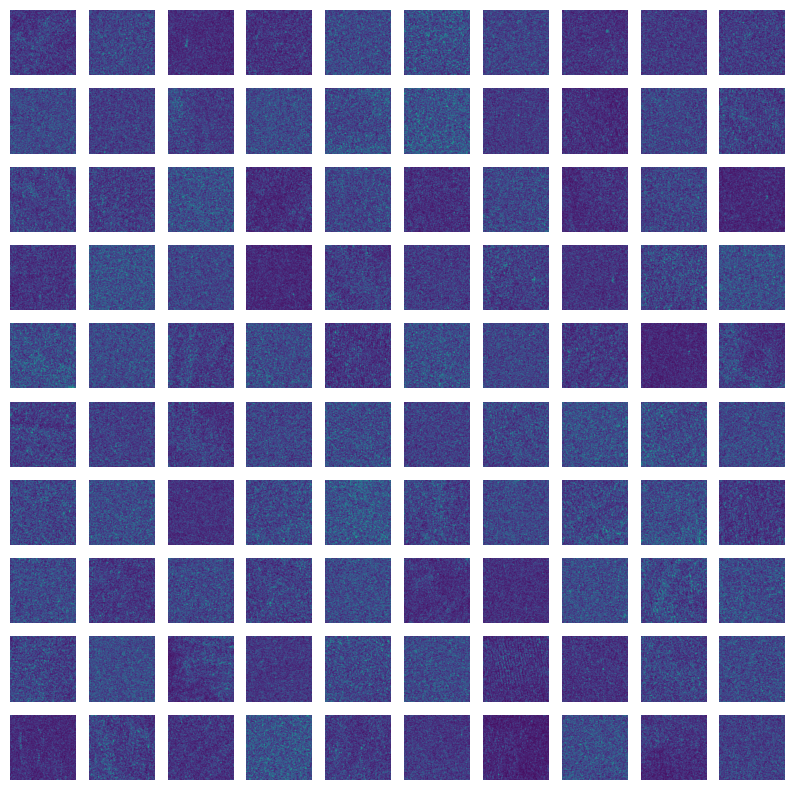

In [44]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
images = [v for v, *_ in islice(sar_gen(), 100)]

for i, ax in enumerate(axes.flat):
    image = images[i]
    ax.imshow(image)
    ax.set_axis_off()

plt.show()

In [67]:
# todo change the names so that they dont use a dash as a separator
def unpack_name(name):
    sar_name, *bouy_name, ix = name.split('.')[0].split('-')
    return sar_name, '-'.join(bouy_name), ix

def get_value(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = shore_survey_df[shore_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [68]:
agg_only_center_dict = defaultdict(list)
for sigma0, pol, name in sar_gen(only_center = True):
    value = get_value(name)
    if value:
        agg_only_center_dict['sigma_mean'].append(sigma0.mean())
        agg_only_center_dict['sigma_var'].append(sigma0.var())
        agg_only_center_dict['sigma_mean_over_var'].append(sigma0.mean() / sigma0.var())

        agg_only_center_dict['value'].append(value)
        agg_only_center_dict['pol'].append(pol)
agg_only_center_df = pd.DataFrame(agg_only_center_dict)
agg_only_center_df

,sigma_mean,sigma_var,sigma_mean_over_var,value,pol
0,0.009586,2.890012e-05,331.691432,0.50,0
1,0.000113,9.791699e-07,115.857578,0.50,1
2,-0.000260,4.928504e-07,-527.334308,0.73,1
3,0.011113,3.807161e-05,291.909684,0.72,0
4,0.000169,1.009686e-06,167.451297,0.72,1
...,...,...,...,...,...
3680,0.010982,3.672299e-05,299.059974,1.08,0
3681,0.000113,5.510983e-07,205.943636,1.08,1
3682,0.030481,2.387627e-04,127.661244,1.07,0
3683,0.000650,2.059772e-06,315.725879,1.07,1


In [72]:
agg_only_center_df.corr()

,sigma_mean,sigma_var,sigma_mean_over_var,value,pol
sigma_mean,1.000000,0.802644,-0.233788,0.382095,-0.593736
sigma_var,0.802644,1.000000,-0.155513,0.318765,-0.239976
sigma_mean_over_var,-0.233788,-0.155513,1.000000,0.105816,0.020495
value,0.382095,0.318765,0.105816,1.000000,-0.041957
pol,-0.593736,-0.239976,0.020495,-0.041957,1.000000


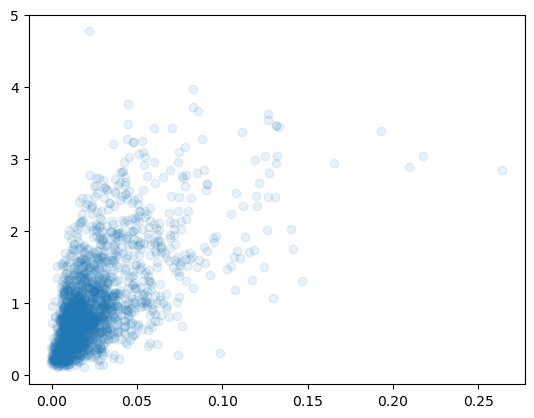

In [93]:
vv_df = agg_only_center_df[agg_only_center_df.pol == 0]
plt.scatter((vv_df.sigma_mean), vv_df.value, alpha=0.1)
plt.show()

In [126]:
from collections import Counter
Counter(name.split('_')[8].split('-')[1] for name in os.listdir(sar_dataset_path))

Counter({'NO': 50296, 'GL': 275})